# On-the-fly statistics

[This note-book is in oceantracker/tutorials_how_to/]

Scaling up particle numbers to millions will create large volumes of
particle track data. Storing and analyzing these tracks is slow and
rapidly becomes overwhelming. For example, building a heat map from a
terabyte of particle tracks after a run has completed. Ocean tracker can
build some particle statistics on the fly, without recording any
particle tracks. This results in more manageable data volumes and
analysis.

On-the-fly statistics record particle counts separately for each release group. It is also possible to subset the counts, ie only count particles which are stranded by the
tide by designating a range of particle status values to count. Or, only
count particles in a given vertical “z” range. Users can add multiple
statistics, all calculated in from the same particles during the run.
Eg. could add a particle statistic for each status type, for different
depth ranges.

Statistics can be read, plotted or animated with OceanTrackers
post-processing code, see below

The available “particle_statistics” classes with their individual
settings are at …. add link

Currently there are two main classes of 2D particle statistics "gridded" which counts particles inside cells of a regular grid, and "polygon" which counts particles in a given list of polygons.

The user can add many particle statistics classes, all based on the same particles. For both types it is possible to only count a subset of these particles, by setting a min. and/or max status to count, or setting a min. and/or max. "z", the vertical location. So could  add several statistics classes, each counting particles in different layers, or classes to separately count those moving and those on the bottom hoping to be re-suspended.

## Gridded statistics

These are heat maps of counts binned into cells of a regular grid. Along
with heat maps of particle counts, users can optionally build a heat
maps of named particle properties, eg. the value decaying particle
property. To ensure the heat map grids are not too large or too coarse,
by default grids are centred on each release group, thus there are
different grid locations for each release group.

## Polygon statistics

These particle counts can be used to calculate the connectivity between
each release group and a user given list of “statistics” polygons. Also,
used to estimate the influence of each release group on a particle
property with each given statistics polygon. The statistics polygons are
not the same as those used in a polygon release (they can be if the user
requires it). Polygon statistics show effect of each point or polygon
release, on the given statistics polygons. A special case of a polygon
statistic, is the “residence_time” class, which can be used to calculate
the fraction of particles from each release group remaining within each
statistics polygon at each ‘update_interval’ as one way to estimate
particle residence time for each release group.

## Particle property statistics

Both types of statistics can also record sums of user designated
particle properties within each given grid cell or statistics polygon,
which originate from each release group. These sums enabling mean values
of designated particle properties within each grid cell or polygon to be
calculated. They can also be used to estimate the relative influence of
each release group on the value of a particle property within each given
grid cell or polygon.

A future version with allow estimating the variance of the designated
property values and particle counts in each grid cell or
polygon, for each release group.





## Gridded/Heat map example

The below uses the helper class method to extends the minimal_example to add

* Decaying particle property, eg. breakdown of a pollutant
* Gridded  time series of particle statistics as heat maps, which also builds a heat map of the pollutant
* Plot the particle counts and pollutant as animated heatmap.


In [3]:
# Gridded Statistics example.py using class helper method
#------------------------------------------------
from oceantracker.main import OceanTracker

# make instance of oceantracker to use to set parameters using code, then run
ot = OceanTracker()

# ot.settings method use to set basic settings
ot.settings(output_file_base='heat_map_example', # name used as base for output files
            root_output_dir='output',             #  output is put in dir   'root_output_dir'\\'output_file_base'
            time_step= 600. #  10 min time step as seconds
            )
# ot.set_class, sets parameters for a named class
ot.add_class('reader',input_dir= '../demos/demo_hindcast',  # folder to search for hindcast files, sub-dirs will, by default, also be searched
                      file_mask=  'demoHindcastSchism*.nc')  # hindcast file mask

# add one release locations 
ot.add_class('release_groups', name='my_release_point', # user must provide a name for group first
                        points= [ [1599000, 5486200]],       # ust be 1 by N list pairs of release locations
                        release_interval= 900,           # seconds between releasing particles
                        pulse_size= 1000,                   # number of particles released each release_interval
            )

# add a decaying particle property
# add and Age decay particle property, with exponential decay based on age, with time scale 1 hour                             
ot.add_class('particle_properties', # add a new property to particle_properties role
            name ='a_pollutant', # must have a user given name
            class_name='oceantracker.particle_properties.age_decay.AgeDecay', #  class_role is resuspension
            initial_value= 1000,
            decay_time_scale = 3600.) # time scale of age decay ie decays initial_value* exp(-age/decay_time_scale)

# add a gridded particle statistic 
ot.add_class('particle_statistics', 
                name = 'my_heatmap',
                class_name= 'oceantracker.particle_statistics.gridded_statistics.GriddedStats2D_timeBased',
                # the below settings are optional
                update_interval = 900, # time interval in sec, between doing particle statists counts 
                particle_property_list = ['a_pollutant'], # request a heat map for the decaying part. prop. added above
                status_min ='moving', # only count the particles which are moving 
                z_mi =-2.,  # only count particles at locations above z=-2m
                grid_size= [120, 121]  # number of east and north cells in the heat map
                )


# run oceantracker
case_info_file_name = ot.run()

main: --------------------------------------------------------------------------
main: OceanTracker- preliminary setup
main:      Python version: 3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
main:   - found hydro-model files of type SCHISIM
main:       -  sorted hyrdo-model files in time order,	  0.008 sec
main:     >>> Note: output is in dir= e:\H_Local_drive\ParticleTracking\oceantracker\tutorials_how_to\output\heat_map_example
main:     >>> Note: to help with debugging, parameters as given by user  are in "heat_map_example_raw_user_params.json"
C000: --------------------------------------------------------------------------
C000: Starting case number   0,  heat_map_example at 2023-06-21T13:22:27.378051
C000: --------------------------------------------------------------------------
C000:       -  built node to triangles map,	  0.000 sec
C000:       -  built triangle adjacency matrix,	  0.000 sec
C000:       -  found boundary triangles,

### Read and plot heat maps

The statistics output from the above run is in file 
output\heat_map_example\heat_map_example_stats_gridded_time_my_heatmap.nc 

This netcdf file  can be read and organized as a python dictionary by
directly with read_ncdf_output_files.read_stats_file.

To plot use, load_output_files.load_stats_data, which also loads grid etc for plotting

raw_stats dict_keys(['total_num_particles_released', 'release_groupID_my_release_point', 'dimensions', 'limits', 'release_groupID', 'release_locations', 'y', 'time', 'number_released_each_release_group', 'count', 'grid_cell_area', 'number_of_release_points', 'count_all_particles', 'is_polygon_release', 'x', 'num_released', 'release_points', 'sum_a_pollutant', 'time_var', 'stats_type', 'a_pollutant'])
stats dict_keys(['total_num_particles_released', 'release_groupID_my_release_point', 'dimensions', 'limits', 'release_groupID', 'release_locations', 'y', 'time', 'number_released_each_release_group', 'count', 'grid_cell_area', 'number_of_release_points', 'count_all_particles', 'is_polygon_release', 'x', 'num_released', 'release_points', 'sum_a_pollutant', 'time_var', 'stats_type', 'a_pollutant', 'info', 'params', 'release_group_centered_grids', 'particle_status_flags', 'particle_release_groups', 'full_case_params', 'grid'])
animate_heat_map> colour axis limits [0, 4028] [0, 4028]


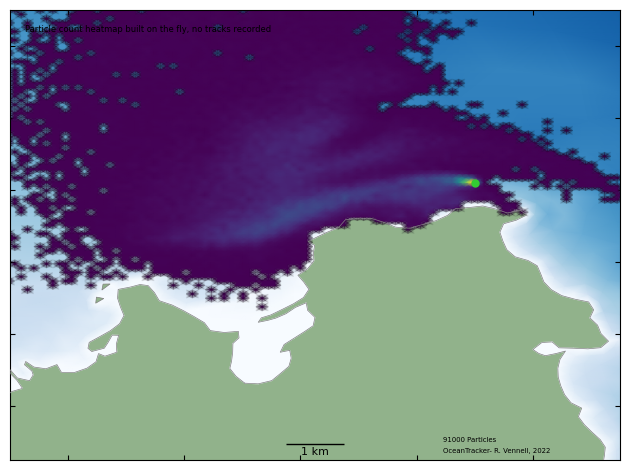

animate_heat_map> colour axis limits [1.4321606718741004e-07, 1000.0] [1.4321606718741004e-07, 1000.0]


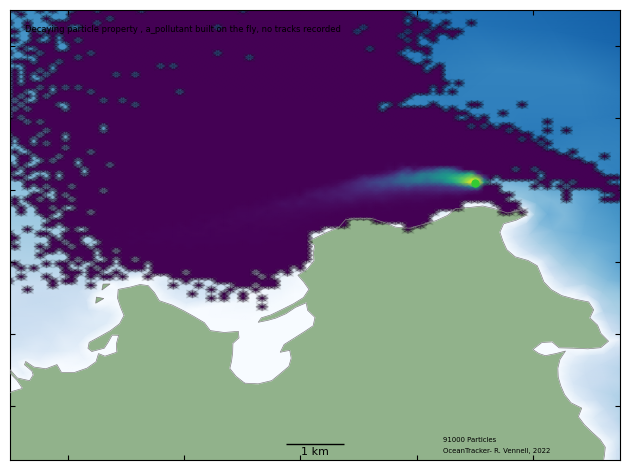

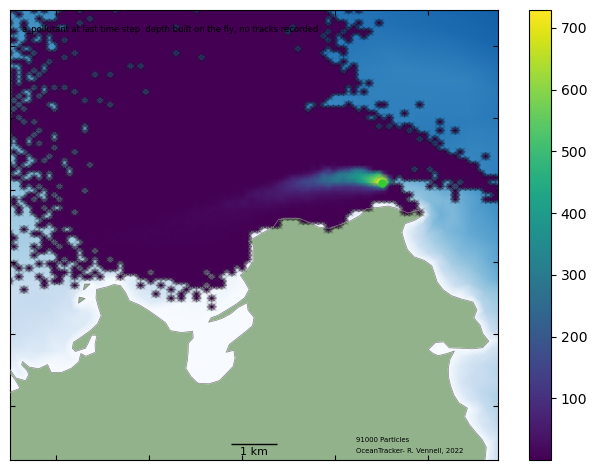

In [6]:
# read stats files
from oceantracker.post_processing.read_output_files import read_ncdf_output_files, load_output_files
from oceantracker.post_processing.plotting import plot_statistics
from IPython.display import HTML

# basic read of net cdf
raw_stats = read_ncdf_output_files.read_stats_file('output\heat_map_example\heat_map_example_stats_gridded_time_my_heatmap.nc')
print('raw_stats', raw_stats.keys())

# better,  load netcdf plus grid and other data useful in plotting 
# uses case_info name returned from run above
stats_data = load_output_files.load_stats_data(case_info_file_name,'my_heatmap')
print('stats',stats_data.keys())

# use stats_data variable to plot heat map at last time step, by default plots var= "count"
ax= [1591000, 1601500, 5478500, 5491000] 
anim= plot_statistics.animate_heat_map(stats_data, release_group='my_release_point', axis_lims=ax,
                    heading='Particle count heatmap built on the fly, no tracks recorded', fps=1)
HTML(anim.to_html5_video())# this is slow to build!

# animate the pollutant
anim= plot_statistics.animate_heat_map(stats_data, var='a_pollutant',release_group= 'my_release_point', axis_lims=ax,
                    heading='Decaying particle property , a_pollutant built on the fly, no tracks recorded', fps=1)
HTML(anim.to_html5_video())# this is slow to build!


# static heat map
plot_statistics.plot_heat_map(stats_data, var='a_pollutant',release_group= 'my_release_point', axis_lims=ax,  heading='a_pollutant at last time step  depth built on the fly, no tracks recorded')

## Polygon example


    # add polygon stats example with plotting

## Time verses Age statistics

Both gridded and polygon statistics come in two types, “time” and “age”.

*  “time” statistics are time series, or snapshots, of particle numbers
and particle properties at a time interval given by  “calculation_interval” parameter. Eg. gridded stats showing how the  heat map of a source’s plume evolves over time.

*  “age” statistics are particle counts and properties binned by  particle age. The result are age based histograms of counts or particle proprieties. This is useful to give numbers in each age band arriving at a given grid cell or polygon, from each release group.  Eg. counting how many larvae are old enough to settle in a polygon or    grid cell from each potential source location.